In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from semantic_similarity import calculate_semantic_similarity
from sentence_tokenizer import process_directory
from summarization import summarize_document_with_pipeline
import information_clustering
import classification

c:\Users\colli\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Semantic Textual Similarity

In [ ]:
# Process both directories
amici_dir = '../Data/Amici'
opinions_dir = '../Data/Opinions'
metadata_file = '../Data/metadata.csv'
amici_jsonl = '../Data/amici_sentences.jsonl'
opinions_jsonl = '../Data/opinions_sentences.jsonl'

In [ ]:
amici_metadata = process_directory(amici_dir, amici_jsonl)
opinions_metadata = process_directory(opinions_dir, opinions_jsonl)

In [ ]:
# Calculate and save the semantic similarity matrix
results = calculate_semantic_similarity(opinions_jsonl, amici_jsonl, metadata_file, output_dir="../Data/similarity_matrices", threshold=0.9, model_name="sentence-transformers/all-mpnet-base-v2")

In [ ]:
case_of_interest = "Burwell v. Hobby Lobby"

if case_of_interest in results:
    print(f"Highly similar pairs for case '{case_of_interest}':")
    for pair in results[case_of_interest]["highly_similar_pairs"]:
        print("Opinion Sentence:", pair["opinion_sentence"])
        print("Amicus Sentence:", pair["amicus_sentence"])
        print("Similarity Score:", pair["similarity_score"])

In [ ]:
cases = list(results.keys())
percent_copied_values = [results[case]["percent_copied"] for case in cases]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(cases, percent_copied_values, color='mediumseagreen')
plt.axhline(y=2.7, color='black', linestyle='--', label='2.7% (Collins et al., 2015)')
plt.xlabel('Case')
plt.ylabel('Percent Copied')
plt.title('Percent of Opinion Text Similar to Amici Briefs by Case')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()  
plt.show()

In [ ]:
# Initialize variables for calculating averages
total_percent_copied = 0
total_weighted_percent_copied = 0
total_words_in_all_opinions = 0

# Loop through each case in results
for case, case_data in results.items():
    percent_copied = case_data["percent_copied"]
    opinion_length_words = case_data["total_words"]  # Ensure this is in the results data

    # Add to the simple total
    total_percent_copied += percent_copied
    
    # Add to the weighted total
    total_weighted_percent_copied += percent_copied * opinion_length_words
    total_words_in_all_opinions += opinion_length_words

# Calculate averages
num_cases = len(results)
simple_average = total_percent_copied / num_cases if num_cases > 0 else 0
weighted_average = (total_weighted_percent_copied / total_words_in_all_opinions) if total_words_in_all_opinions > 0 else 0

# Print the results
print(f"Simple Average Percentage of Text Copied: {simple_average:.2f}%")
print(f"Opinion-Length Weighted Average Percentage of Text Copied: {weighted_average:.2f}%")


# Classificaiton

In [ ]:
# Model configurations
model_info = {
    'bert-base': 'google-bert/bert-base-uncased',
    'bert-large': 'google-bert/bert-large-uncased',
    'bart-base': 'facebook/bart-base',
    'bart-large': 'facebook/bart-large',
    'gte-small': 'thenlper/gte-small',
    'gte-base': 'thenlper/gte-base',
    'gte-large': 'thenlper/gte-large',
    'Granite-30m': 'ibm-granite/granite-embedding-30m-english',
    'Granite-125m': 'ibm-granite/granite-embedding-125m-english',
    'Granite-107m': 'ibm-granite/granite-embedding-107m-multilingual',
    'Granite-278m': 'ibm-granite/granite-embedding-278m-multilingual',
    'ModernBERT-base': 'answerdotai/ModernBERT-base',
    'ModernBERT-large': 'answerdotai/ModernBERT-large'
}

# Initialize results storage
all_results = []

# Process each embedding model
for model_name, model_path in model_info.items():
    # Create embeddings
    X, labels_df = classification.create_document_embeddings(
        data_dirs=["../Data/Amici", "../Data/Opinions"],
        metadata_file="../Data/metadata.csv",
        model_name=model_name,
        model_path=model_path
    )
    
    # Create labels (1 for opinions, 0 for amici)
    y = np.array([1 if "Opinions" in row['directory'] else 0 for _, row in labels_df.iterrows()])
    
    # Evaluate models and store results
    results_df = classification.evaluate_models(X, y, model_name)
    all_results.append(results_df)

# Combine and save all results
final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv('..Results/model_roc_auc_results.csv', index=False)
print("\nResults saved to model_roc_auc_results.csv")

# Information Clustering

Token indices sequence length is longer than the specified maximum sequence length for this model (9611 > 4096). Running this sequence through the model will result in indexing errors


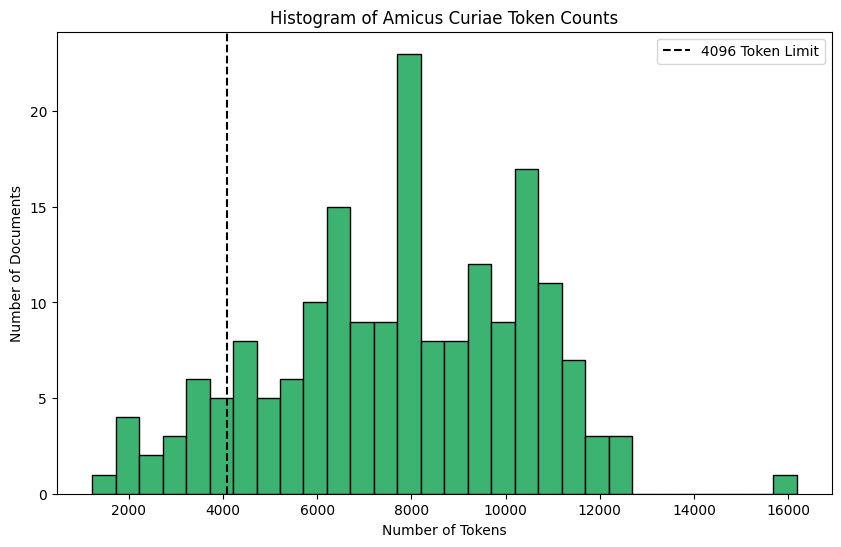

In [2]:
# Initialize the tokenizer
model_name = 'google/bigbird-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def count_tokens(directory):
    token_counts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()

            # Tokenize the text to count tokens
            tokens = tokenizer(text, truncation=False)
            num_tokens = len(tokens['input_ids'])
            token_counts.append(num_tokens)

    return token_counts

# Count tokens in each document
directory = "../Data/Amici"
token_counts = count_tokens(directory)

# Plot histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color='mediumseagreen', edgecolor='black')
plt.axvline(x=4096, color='black', linestyle='--', label='4096 Token Limit')
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.title("Histogram of Amicus Curiae Token Counts")
plt.legend()
plt.show()

In [3]:
# Define paths and call the embedding creation function
DATA_DIRS = ["../Data/Amici"]
METADATA_FILE = "../Data/metadata.csv"
OUTPUT_EMBEDDINGS = "../Results/clustering_embeddings.pt"
OUTPUT_LABELS = "../Data/labels.csv"



In [4]:
information_clustering.create_document_embeddings(DATA_DIRS, METADATA_FILE, OUTPUT_EMBEDDINGS, OUTPUT_LABELS)

Processing ../Data/Amici: 100%|██████████| 185/185 [1:10:24<00:00, 22.83s/it]


Embeddings saved to ../Results/clustering_embeddings.pt
Labels saved to ../Data/labels.csv


c:\Users\colli\OneDrive\Documents\School\Research\CRRD\LLMs Survey for Political Science\llm-for-political-science\Code\information_clustering.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

Clustering adjusted rand score: 0.1920982235709573


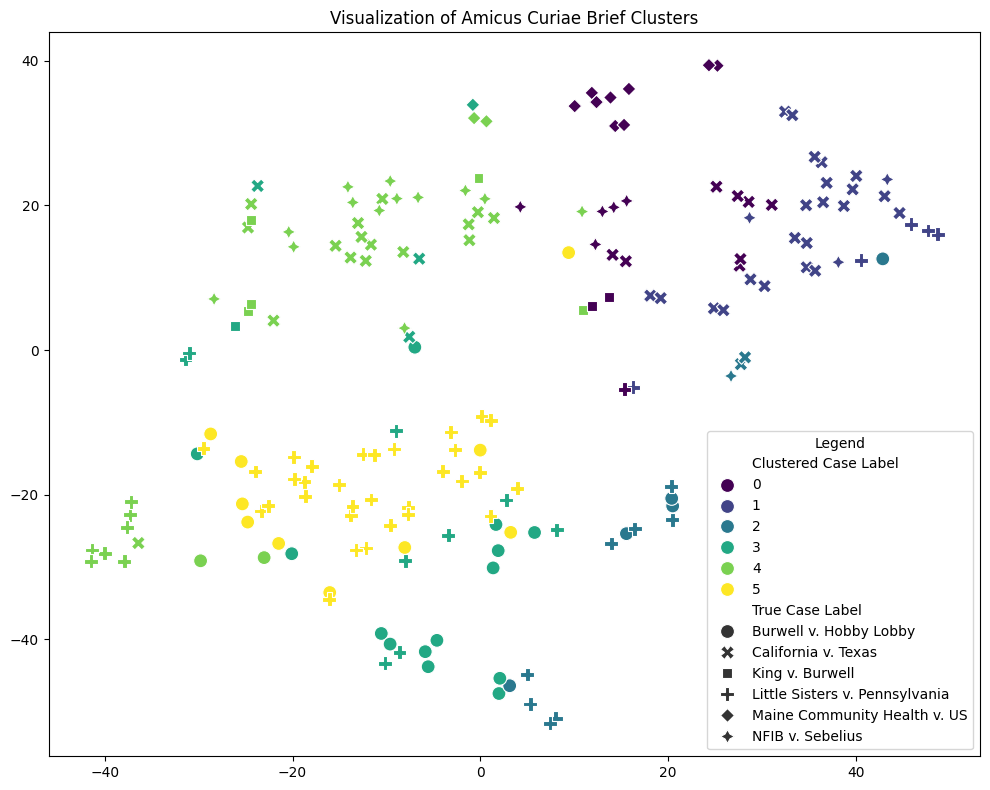

In [5]:
# Define paths and call the clustering and visualization function
N_CLUSTERS = 6
OUTPUT_PLOT = "../Data/clustering_visualization.png"
information_clustering.perform_clustering_and_visualize(OUTPUT_EMBEDDINGS, OUTPUT_LABELS, N_CLUSTERS, OUTPUT_PLOT)

# Summarization

In [ ]:
# Example usage
file_path = "../Data/nfib v sebelius syllabus.txt"
model_names = [
    "google/flan-t5-small",
    "google/flan-t5-base",
    "google/flan-t5-large",
    "google/flan-t5-xl"]

summaries = summarize_document_with_pipeline(file_path, model_names, max_input_length=512)


model_names = [
    "allenai/led-base-16384",
    "allenai/led-base-16384-ms2",
    "allenai/led-base-16384-cochrane",
    "allenai/led-large-16384", 
    "allenai/led-large-16384-arxiv", 
]
summaries = summarize_document_with_pipeline(file_path, model_names, max_input_length=2900)